In [1]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_distances
from transformers import AutoTokenizer, AutoModel
from collections import defaultdict
from scipy.stats import entropy
from vendi_score import text_utils
from tqdm import tqdm 

/etc/python/sitecustomize.py:117: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  mod = _original_import(name, globals, locals, fromlist, level)


In [2]:
model_name = 'sentence-transformers/all-mpnet-base-v2'

In [3]:
def encode_sentences(sentences, tokenizer, model, device):
    encoded = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)
    encoded = {k: v.to(device) for k, v in encoded.items()}
    with torch.no_grad():
        output = model(**encoded)
    embeddings = output.last_hidden_state.mean(dim=1)  # Mean pooling
    return embeddings.cpu().numpy()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

In [5]:
story = pd.read_csv('data/text/with_metrics/decTest/dec_test_1000_no_hds_story_gen.csv')
resp = pd.read_csv('data/text/with_metrics/decTest/dec_test_1000_no_hds_resp_gen.csv')
prompt = pd.read_csv('data/text/with_metrics/decTest/dec_test_1000_no_hds_prompt_gen.csv')

In [6]:
def encode_dataframe(df, tokenizer, model, device, cols=None):
    """
    Encode each column [resp_0 ... resp_9] of a DataFrame into embeddings.
    
    Returns:
        np.ndarray of shape (n_rows, n_cols, embedding_dim)
    """
    if cols is None:
        cols = [f"resp_{i}" for i in range(10)]
    
    n_rows = len(df)
    n_cols = len(cols)
    
    # Determine embedding dimension by encoding first non-empty sentence
    for c in cols:
        first_text = str(df[c].dropna().iloc[0])
        if first_text.strip() != "":
            emb_dim = encode_sentences([first_text], tokenizer, model, device).shape[1]
            break

    all_embeddings = np.zeros((n_rows, n_cols, emb_dim), dtype=np.float32)

    for i, row in enumerate(tqdm(df.itertuples(index=False), total=n_rows)):
        row_embeddings = []
        for j, col in enumerate(cols):
            text = str(getattr(row, col))
            if text.strip() == "":
                row_embeddings.append(np.zeros(emb_dim, dtype=np.float32))
            else:
                emb = encode_sentences([text], tokenizer, model, device)[0]
                row_embeddings.append(emb)
        all_embeddings[i] = np.stack(row_embeddings)
    
    return all_embeddings

In [7]:
emb_story = encode_dataframe(story, tokenizer, model, device)
emb_resp = encode_dataframe(resp, tokenizer, model, device)
emb_prompt = encode_dataframe(prompt, tokenizer, model, device)
print(emb_story.shape)
print(emb_resp.shape)
print(emb_prompt.shape)

100%|██████████| 1000/1000 [01:54<00:00,  8.75it/s]

(985, 10, 768)
(994, 10, 768)
(1000, 10, 768)


Diversity Measure

In [8]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold

from PLDiv import compute_PLDiv

import time

In [9]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize

def compute_pldiv_by_embedding(embeddings, metric="euclidean"):
    if metric == "euclidean":
        embeddings = normalize(embeddings.reshape(-1, embeddings.shape[-1]), axis=1).reshape(embeddings.shape)
    features = []
    for i in range(embeddings.shape[0]):
        dist_matrix = cdist(embeddings[i], embeddings[i], metric=metric)
        feat = compute_PLDiv(dist_matrix, hom_deg=0, sparse=None, closed_form=False, distance_matrix=True) 
        features.append(feat)
    return np.array(features).reshape(embeddings.shape[0], -1)

In [10]:
# VS 
from vendi_score import data_utils, vendi
def embedding_vendi_score(
    X, batch_size=64, device="cpu", model=None, transform=None, normalize = True
):
    n, d = X.shape
    if n < d:
        return vendi.score_X(X, normalize = True)
    return vendi.score_dual(X, normalize = True)

In [11]:
# DCS
from sklearn import preprocessing

def calculate_dcscore_by_embedding(embeddings_arr, kernel_type='cs', tau=1):
    if kernel_type == 'cs':
        # cosine similarity as teh kernel function
        embeddings_arr = preprocessing.normalize(embeddings_arr, axis=1)
        sim_product = torch.from_numpy((embeddings_arr @ embeddings_arr.T) / tau)
        sim_probs = sim_product.softmax(dim=-1)
        diversity = torch.sum(torch.diag(sim_probs))
    elif kernel_type == 'rbf':
        sim_mat = rbf_kernel(embeddings_arr, embeddings_arr, tau)
        sim_probs = torch.nn.functional.softmax(torch.from_numpy(sim_mat), dim=-1)
        diversity = torch.sum(torch.diag(sim_probs))
    elif kernel_type == 'lap':
        sim_mat = laplacian_kernel(embeddings_arr, embeddings_arr, tau)
        sim_probs = torch.nn.functional.softmax(torch.from_numpy(sim_mat), dim=-1)
        diversity = torch.sum(torch.diag(sim_probs))
    elif kernel_type == 'poly':
        sim_mat = polynomial_kernel(embeddings_arr, embeddings_arr, tau)
        sim_probs = torch.nn.functional.softmax(torch.from_numpy(sim_mat), dim=-1)
        diversity = torch.sum(torch.diag(sim_probs))
    
    return diversity.item()

In [12]:
start_time = time.time() 

pld_story = compute_pldiv_by_embedding(emb_story, metric = 'euclidean')
pld_resp = compute_pldiv_by_embedding(emb_resp, metric = 'euclidean')
pld_prompt = compute_pldiv_by_embedding(emb_prompt, metric = 'euclidean')

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

Runtime: 6.204 seconds


In [13]:
start_time = time.time() 

vs_story = [embedding_vendi_score(emb)  for emb in emb_story]
vs_resp = [embedding_vendi_score(emb)  for emb in emb_resp]
vs_prompt = [embedding_vendi_score(emb)  for emb in emb_prompt]

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

Runtime: 0.714 seconds


In [14]:
start_time = time.time() 

dcs_story = [calculate_dcscore_by_embedding(emb)  for emb in emb_story]
dcs_resp = [calculate_dcscore_by_embedding(emb)  for emb in emb_resp]
dcs_prompt = [calculate_dcscore_by_embedding(emb)  for emb in emb_prompt]

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

Runtime: 157.268 seconds


In [15]:
from magnipy.diversipy import Diversipy

start_time = time.time() 

mag_story = []
failed_indices = []

for i, emb in enumerate(emb_story):
    try:
        # Create Diversipy object for a single dataset
        div = Diversipy(Xs=[emb], ref_space=0, metric="euclidean")
        area = div.MagAreas()  # MagAreas returns a list
        mag_story.append(area)
    except ValueError as e:
        print(f"Dataset {i} failed: {e}")
        mag_story.append(0)       # assign 0 for failure
        failed_indices.append(i)

# mag_story = np.array(mag_story)
# print("MagAreas:", mag_story)
# print("Failed indices:", failed_indices)


mag_prompt = []

for i, emb in enumerate(emb_prompt):
    try:
        # Create Diversipy object for a single dataset
        div = Diversipy(Xs=[emb], ref_space=0, metric="euclidean")
        area = div.MagAreas()  # MagAreas returns a list
        mag_prompt.append(area)
    except ValueError as e:
        print(f"Dataset {i} failed: {e}")
        mag_prompt.append(0)       # assign 0 for failure
        failed_indices.append(i)

# mag_story = np.array(mag_story)
# print("MagAreas:", mag_prompt)
# print("Failed indices:", failed_indices)



mag_resp = []

for i, emb in enumerate(emb_resp):
    try:
        # Create Diversipy object for a single dataset
        div = Diversipy(Xs=[emb], ref_space=0, metric="euclidean")
        area = div.MagAreas()  # MagAreas returns a list
        mag_resp.append(area)
    except ValueError as e:
        print(f"Dataset {i} failed: {e}")
        mag_resp.append(0)       # assign 0 for failure
        failed_indices.append(i)

# mag_story = np.array(mag_story)
# print("MagAreas:", mag_story)
# print("Failed indices:", failed_indices)

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

Out of the 10 observations in X, only 6 are unique.
Out of the 10 observations in X, only 6 are unique.
Out of the 10 observations in X, only 6 are unique.
Out of the 10 observations in X, only 6 are unique.
Out of the 10 observations in X, only 3 are unique.
Out of the 10 observations in X, only 3 are unique.
Out of the 10 observations in X, only 9 are unique.
Out of the 10 observations in X, only 9 are unique.
Out of the 10 observations in X, only 8 are unique.
Out of the 10 observations in X, only 8 are unique.
Out of the 10 observations in X, only 6 are unique.
Out of the 10 observations in X, only 6 are unique.
Out of the 10 observations in X, only 8 are unique.
Out of the 10 observations in X, only 8 are unique.
Out of the 10 observations in X, only 8 are unique.
Out of the 10 observations in X, only 8 are unique.
Out of the 10 observations in X, only 8 are unique.
Out of the 10 observations in X, only 8 are unique.
Out of the 10 observations in X, only 2 are unique.
Out of the 1

In [16]:
mag_story = [float(x[0]) if isinstance(x, (list, np.ndarray)) else float(x) for x in mag_story]
mag_prompt = [float(x[0]) if isinstance(x, (list, np.ndarray)) else float(x) for x in mag_prompt]
mag_resp = [float(x[0]) if isinstance(x, (list, np.ndarray)) else float(x) for x in mag_resp]

In [17]:
story_y = story['label_value']
resp_y = resp['label_value']
prompt_y = prompt['label_value']

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

def evaluate_reg(X, y, random_state=42, n_repeats=10):

    X = np.asarray(X).reshape(-1, 1)
    y = np.asarray(y)

    reg = LinearRegression()

    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)
    cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=random_state)
    results = cross_validate(
        reg,
        X,
        y,
        scoring={"mse": mse_scorer, "r2": r2_scorer},
        cv=cv,
        n_jobs=-1
    )

    # --- Compute summary stats ---
    mse_mean, mse_std = -results["test_mse"].mean(), results["test_mse"].std()
    r2_mean, r2_std = results["test_r2"].mean(), results["test_r2"].std()

    print(f"Mean MSE: {mse_mean:.3f} ± {mse_std:.3f}")
    print(f"Mean R²: {r2_mean:.3f} ± {r2_std:.3f}")

    # return {
    #     "mse_mean": mse_mean,
    #     "mse_std": mse_std,
    #     "r2_mean": r2_mean,
    #     "r2_std": r2_std
    # }

In [19]:
print(evaluate_reg(pld_story, story_y))
print(evaluate_reg(vs_story, story_y))
print(evaluate_reg(dcs_story, story_y))
print(evaluate_reg(mag_story, story_y))

Mean MSE: 0.041 ± 0.004
Mean R²: 0.518 ± 0.048
None
Mean MSE: 0.042 ± 0.004
Mean R²: 0.505 ± 0.050
None
Mean MSE: 0.047 ± 0.005
Mean R²: 0.445 ± 0.057
None
Mean MSE: 0.053 ± 0.005
Mean R²: 0.379 ± 0.054
None


In [20]:
print(evaluate_reg(pld_prompt, prompt_y))
print(evaluate_reg(vs_prompt, prompt_y))
print(evaluate_reg(dcs_prompt, prompt_y))
print(evaluate_reg(mag_prompt, prompt_y))

Mean MSE: 0.035 ± 0.003
Mean R²: 0.600 ± 0.040
None
Mean MSE: 0.038 ± 0.003
Mean R²: 0.556 ± 0.040
None
Mean MSE: 0.042 ± 0.004
Mean R²: 0.513 ± 0.043
None
Mean MSE: 0.081 ± 0.005
Mean R²: 0.063 ± 0.043
None


In [21]:
print(evaluate_reg(pld_resp, resp_y))
print(evaluate_reg(vs_resp, resp_y))
print(evaluate_reg(dcs_resp, resp_y))
print(evaluate_reg(mag_resp, resp_y))

Mean MSE: 0.031 ± 0.002
Mean R²: 0.641 ± 0.034
None
Mean MSE: 0.034 ± 0.002
Mean R²: 0.603 ± 0.037
None
Mean MSE: 0.039 ± 0.003
Mean R²: 0.552 ± 0.033
None
Mean MSE: 0.074 ± 0.005
Mean R²: 0.144 ± 0.043
None


In [22]:
import numpy as np
from scipy.stats import spearmanr, pearsonr

def bootstrap_corr(x, y, method="pearson", n_bootstrap=1000, ci=95, random_state=None):
    """
    Compute correlation (Spearman or Pearson) with bootstrap CI.

    Parameters
    ----------
    x, y : array-like
        Input variables (same length).
    method : {"spearman", "pearson"}
        Correlation type to compute.
    n_bootstrap : int
        Number of bootstrap resamples (default=1000).
    ci : float
        Confidence interval width (default=95).
    random_state : int or None
        Random seed for reproducibility.

    Returns
    -------
    corr : float
        Correlation coefficient.
    ci_lower, ci_upper : float
        Lower and upper bounds of the bootstrap confidence interval.
    """
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    n = len(x)
    rng = np.random.default_rng(random_state)

    # Choose correlation function
    if method == "spearman":
        corr_func = spearmanr
    elif method == "pearson":
        corr_func = pearsonr
    else:
        raise ValueError("method must be 'spearman' or 'pearson'")

    # Observed correlation
    corr, _ = corr_func(x, y)

    # Bootstrap
    boot_corrs = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, n)
        c, _ = corr_func(x[idx], y[idx])
        boot_corrs.append(c)

    # Confidence interval
    alpha = (100 - ci) / 2
    lower = np.percentile(boot_corrs, alpha)
    upper = np.percentile(boot_corrs, 100 - alpha)

    return round(corr, 2), round(lower, 2), round(upper, 2)

In [23]:
print(bootstrap_corr(pld_prompt, prompt_y, method="pearson", n_bootstrap=1000, ci=95, random_state=42))
print(bootstrap_corr(vs_prompt, prompt_y, method="pearson", n_bootstrap=1000, ci=95, random_state=42))
print(bootstrap_corr(dcs_prompt, prompt_y, method="pearson", n_bootstrap=1000, ci=95, random_state=42))
print(bootstrap_corr(mag_prompt, prompt_y, method="pearson", n_bootstrap=1000, ci=95, random_state=42))

(np.float64(0.78), np.float64(0.75), np.float64(0.8))
(np.float64(0.75), np.float64(0.72), np.float64(0.78))
(np.float64(0.72), np.float64(0.69), np.float64(0.75))
(np.float64(0.27), np.float64(0.2), np.float64(0.33))


In [24]:
print(bootstrap_corr(pld_resp, resp_y, method="pearson", n_bootstrap=1000, ci=95, random_state=42))
print(bootstrap_corr(vs_resp, resp_y, method="pearson", n_bootstrap=1000, ci=95, random_state=42))
print(bootstrap_corr(dcs_resp, resp_y, method="pearson", n_bootstrap=1000, ci=95, random_state=42))
print(bootstrap_corr(mag_resp, resp_y, method="pearson", n_bootstrap=1000, ci=95, random_state=42))

(np.float64(0.8), np.float64(0.78), np.float64(0.82))
(np.float64(0.78), np.float64(0.76), np.float64(0.8))
(np.float64(0.75), np.float64(0.72), np.float64(0.77))
(np.float64(0.39), np.float64(0.34), np.float64(0.43))


In [25]:
print(bootstrap_corr(pld_story, story_y, method="pearson", n_bootstrap=1000, ci=95, random_state=42))
print(bootstrap_corr(vs_story, story_y, method="pearson", n_bootstrap=1000, ci=95, random_state=42))
print(bootstrap_corr(dcs_story, story_y, method="pearson", n_bootstrap=1000, ci=95, random_state=42))
print(bootstrap_corr(mag_story, story_y, method="pearson", n_bootstrap=1000, ci=95, random_state=42))

(np.float64(0.72), np.float64(0.69), np.float64(0.75))
(np.float64(0.71), np.float64(0.68), np.float64(0.75))
(np.float64(0.67), np.float64(0.63), np.float64(0.71))
(np.float64(0.62), np.float64(0.59), np.float64(0.66))


In [26]:
import matplotlib.pyplot as plt

def plot_corr(x, y, corr, ci, y_name ="DCScore", filename="correlation_plot.png"):
    """
    Scatter plot with correlation coefficient and CI in top-conference style.

    Parameters
    ----------
    x, y : array-like
        Variables to plot.
    corr : float
        Correlation coefficient.
    ci : tuple (lower, upper)
        Confidence interval bounds.
    method : str
        Correlation method name for annotation.
    filename : str
        File to save figure.
    """
    plt.style.use("seaborn-v0_8-whitegrid")

    fig, ax = plt.subplots(figsize=(8, 6))

    # Scatter plot
    ax.scatter(x, y, s=40, alpha=0.7, edgecolor="black", linewidth=0.5, c="#1f77b4")

    # Title and labels
    # ax.set_title(f"{method} Correlation", fontsize=16, fontweight="bold", pad=15)
    ax.set_xlabel("dec", fontsize=13)
    ax.set_ylabel(f"{y_name}", fontsize=13)

    # Annotation for correlation + CI
    ax.text(
        0.05, 0.95,
        f"ρ = {corr:.2f}  (CI: {ci[0]:.2f}, {ci[1]:.2f})",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
    )

    # Grid styling
    ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.7)

    # Ticks
    ax.tick_params(axis="both", labelsize=11)

    # Save
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Plot saved as {filename}")

In [27]:
import os

def process_and_plot(x, y, y_name, prefix, method="pearson", n_bootstrap=1000, ci=95, random_state=42, out_dir="figs"):
    os.makedirs(out_dir, exist_ok=True)
    
    result = bootstrap_corr(x, y, method=method, n_bootstrap=n_bootstrap, ci=ci, random_state=random_state)
    # handle 3-value return
    corr, ci_low, ci_high = result
    ci_vals = (ci_low, ci_high)

    filename = os.path.join(out_dir, f"{prefix}_corr_{y_name.lower().replace(' ', '_')}.png")
    plot_corr(y, x, corr, ci_vals, y_name=y_name, filename=filename)

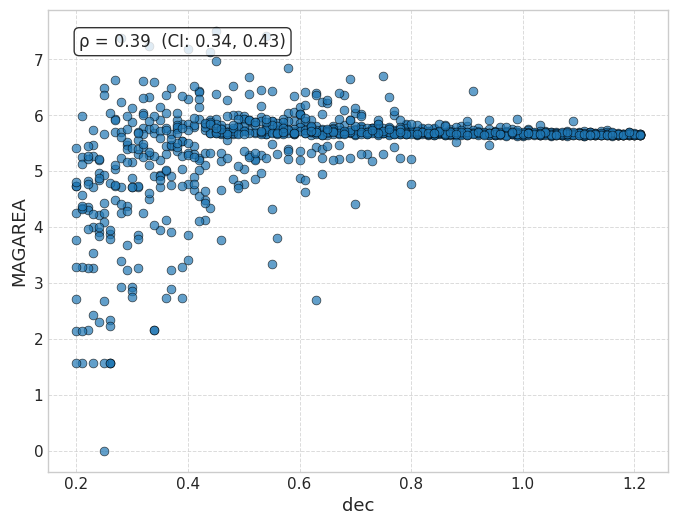

Plot saved as figs/v2_resp_eu_corr_magarea.png


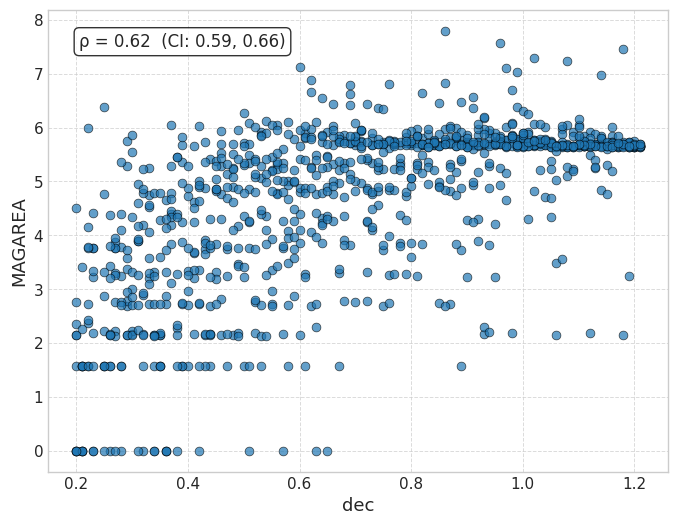

Plot saved as figs/v2_story_eu_corr_magarea.png


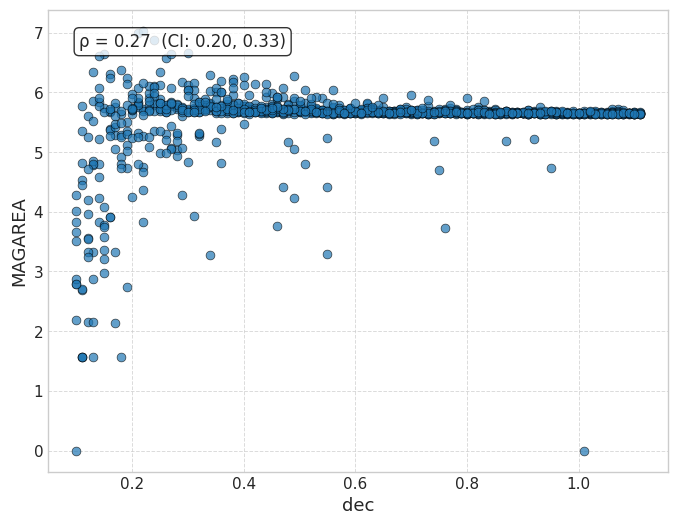

Plot saved as figs/v2_prompt_eu_corr_magarea.png


In [28]:
process_and_plot(mag_resp, resp_y, "MAGAREA", prefix="v2_resp_eu")
process_and_plot(mag_story, story_y, "MAGAREA", prefix="v2_story_eu")
process_and_plot(mag_prompt, prompt_y, "MAGAREA", prefix="v2_prompt_eu")

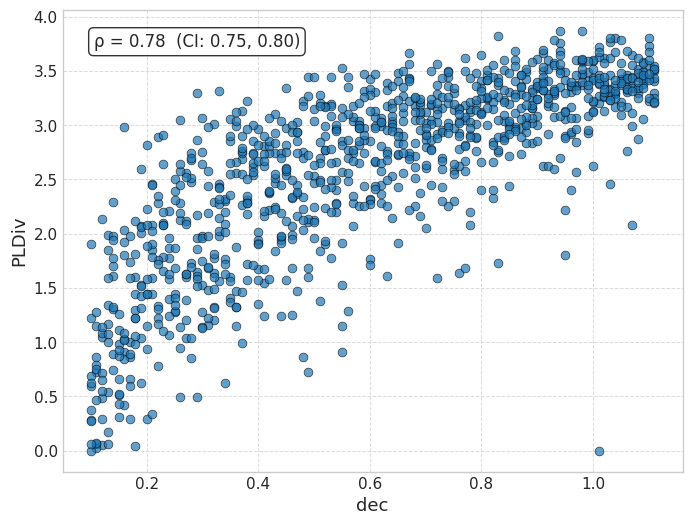

Plot saved as figs/v2_corr_prompt_pld_eu.png


In [32]:
corr, ci = 0.78, (0.75, 0.80)

plot_corr(prompt_y, pld_prompt, corr, ci, y_name ="PLDiv", filename="figs/v2_corr_prompt_pld_eu.png")

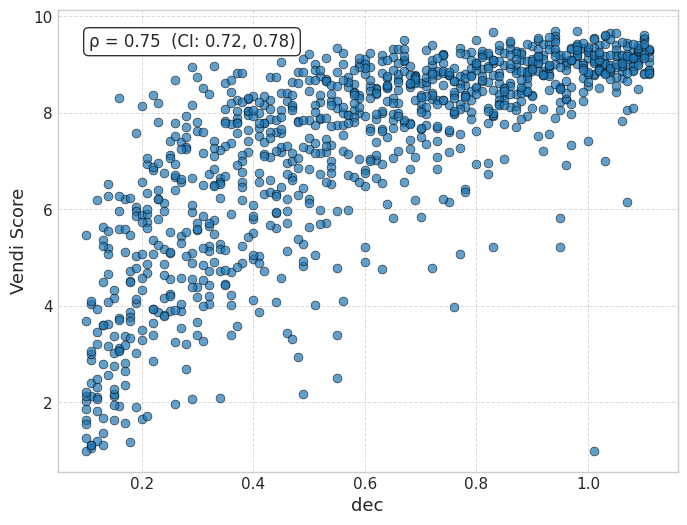

Plot saved as figs/v2_corr_prompt_vs.png


In [ ]:
corr, ci = 0.75, (0.72, 0.78)

plot_corr(prompt_y, vs_prompt, corr, ci, y_name ="Vendi Score", filename="figs/v2_corr_prompt_vs_eu.png")

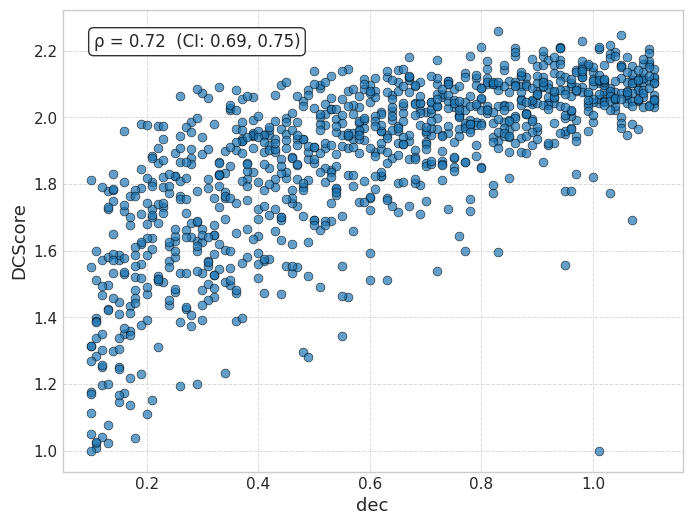

Plot saved as figs/v2_corr_prompt_dcs.png


In [108]:
corr, ci = 0.72, (0.69, 0.75)

plot_corr(prompt_y, dcs_prompt, corr, ci, y_name ="DCScore", filename="figs/v2_corr_prompt_dcs.png")

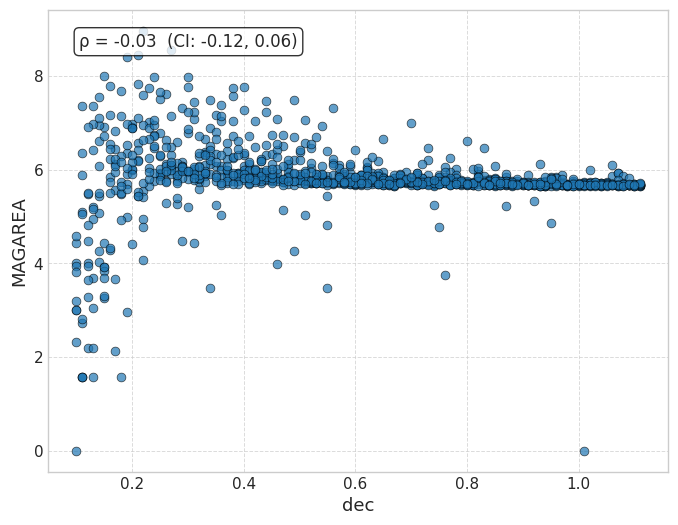

Plot saved as figs/v2_corr_prompt_mag.png


In [109]:
corr, ci = -0.03, (-0.12, 0.06)

plot_corr(prompt_y, mag_prompt, corr, ci, y_name ="MAGAREA", filename="figs/v2_corr_prompt_mag.png")

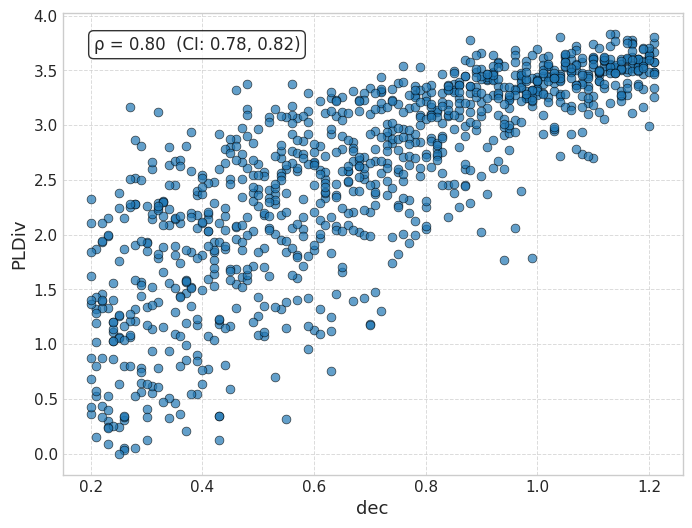

Plot saved as figs/v2_corr_resp_pld_eu.png


In [33]:
corr, ci = 0.8, (0.78, 0.82)

plot_corr(resp_y, pld_resp, corr, ci, y_name ="PLDiv", filename="figs/v2_corr_resp_pld_eu.png")

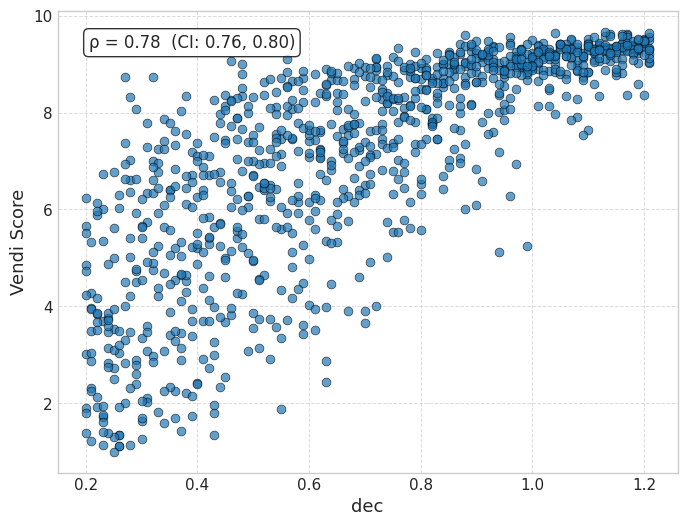

Plot saved as figs/v2_corr_resp_vs.png


In [112]:
corr, ci = 0.78, (0.76, 0.8)

plot_corr(resp_y, vs_resp, corr, ci, y_name ="Vendi Score", filename="figs/v2_corr_resp_vs.png")

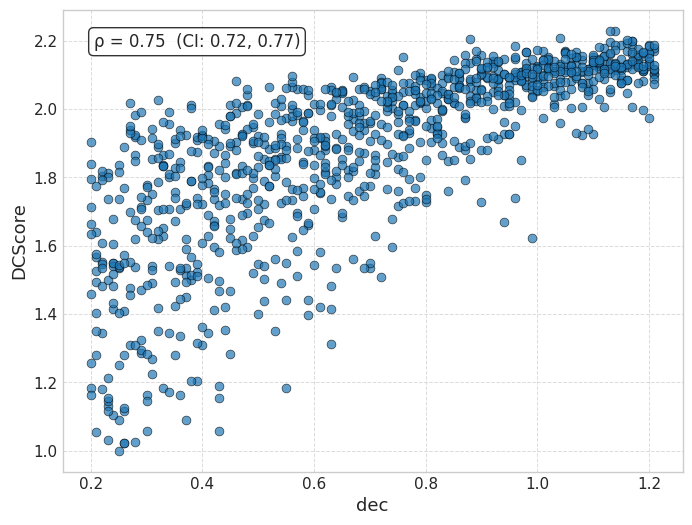

Plot saved as figs/v2_corr_resp_dcs.png


In [113]:
corr, ci = 0.75, (0.72, 0.77)

plot_corr(resp_y, dcs_resp, corr, ci, y_name ="DCScore", filename="figs/v2_corr_resp_dcs.png")

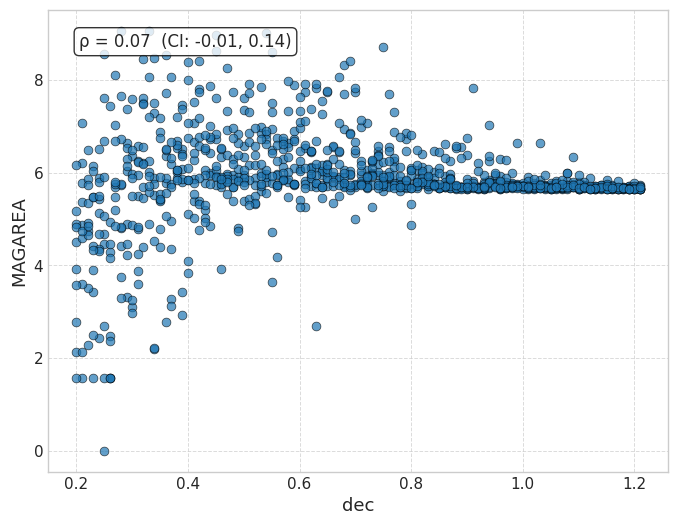

Plot saved as figs/v2_corr_resp_mag.png


In [114]:
corr, ci = 0.07, (-0.01, 0.14)

plot_corr(resp_y, mag_resp, corr, ci, y_name ="MAGAREA", filename="figs/v2_corr_resp_mag.png")

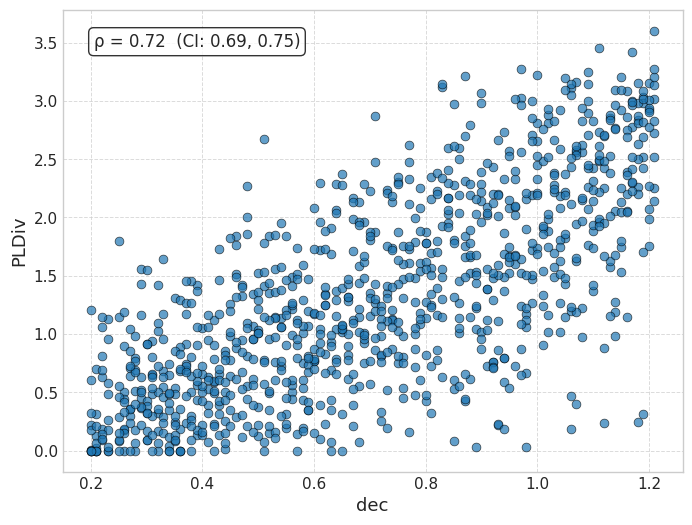

Plot saved as figs/v2_corr_story_pld_eu.png


In [34]:
corr, ci = 0.72, (0.69, 0.75)

plot_corr(story_y, pld_story, corr, ci, y_name ="PLDiv", filename="figs/v2_corr_story_pld_eu.png")

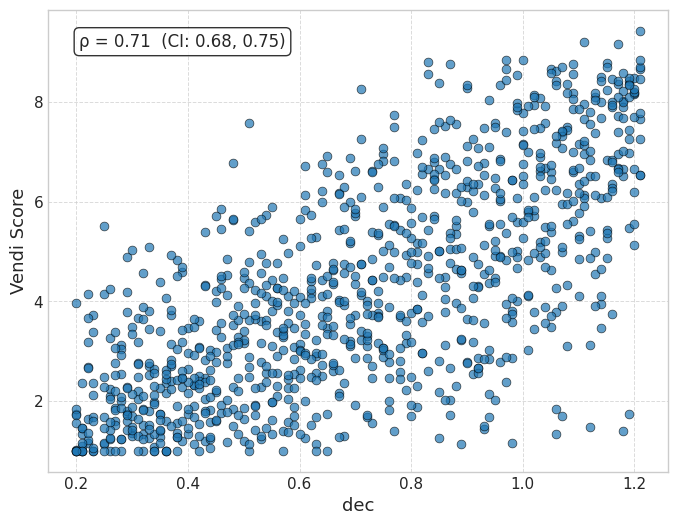

Plot saved as figs/v2_corr_story_vs.png


In [117]:
corr, ci = 0.71, (0.68, 0.75)

plot_corr(story_y, vs_story, corr, ci, y_name ="Vendi Score", filename="figs/v2_corr_story_vs.png")

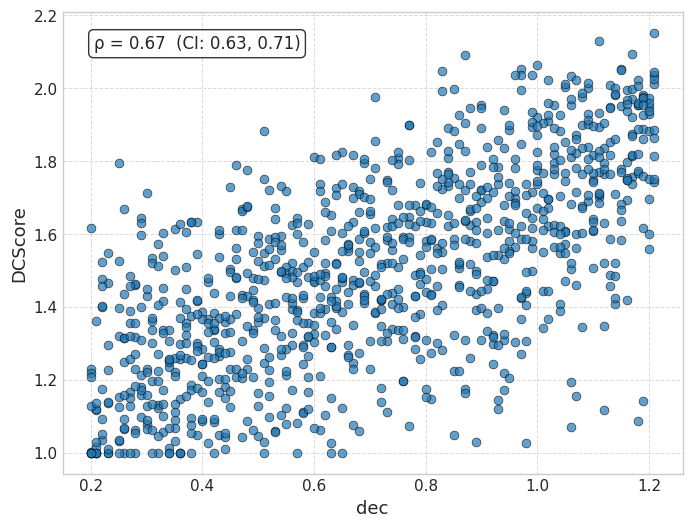

Plot saved as figs/v2_corr_story_dcs.png


In [118]:
corr, ci = 0.67, (0.63, 0.71)

plot_corr( story_y, dcs_story, corr, ci, y_name ="DCScore", filename="figs/v2_corr_story_dcs.png")

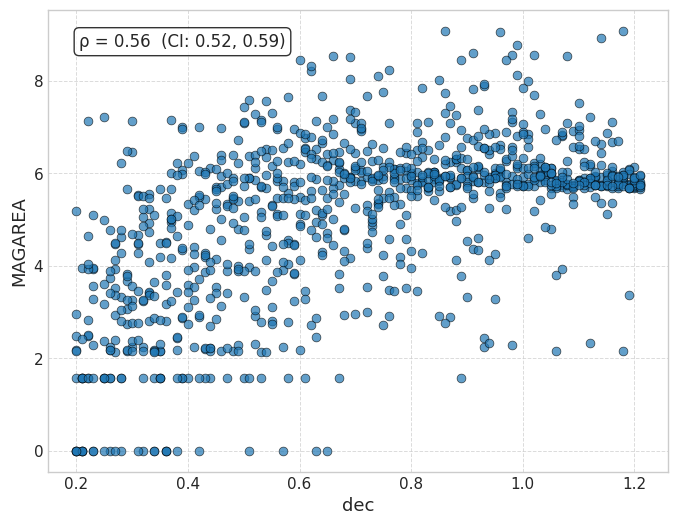

Plot saved as figs/v2_corr_story_mag.png


In [120]:
corr, ci = 0.56, (0.52, 0.59)

plot_corr(story_y, mag_story, corr, ci, y_name ="MAGAREA", filename="figs/v2_corr_story_mag.png")